# Amazon review dataset analysis

# Basic analysis of the full dataset using PySpark

## What's in this section ?
- Here we load large datasets locally using Spark. We first load the full_ratings dataset to vizualise the distribution of the reviews and ratings.
- Then we load the full dataset by category, for the moment we did Electronics and Office products. We use these datasets to vizualise the distribution of the reviews. 

In [1]:
# Import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark import SparkConf
import pandas as pd
import numpy as np


# Import the libraries to draw
import matplotlib.pyplot as plt
import seaborn as sns

# Import helpers functions
from spark_helpers import *

#Create a spark session
spark = SparkSession.builder.appName("Spark Session").config("spark.sql.crossJoin.enabled","true").getOrCreate()
sc = SparkContext.getOrCreate()

## Full Ratings Analysis

Firs, we study the distribution of the full ratings. To do that we load the full ratings (3.37Go) and treat it with PySpark. We will output the distribution of the number of products relative to the number of reviews (i.e 10 products have 15 reviews ...).

In [2]:
# Load the full ratings data
df_full_ratings = spark.read.format('csv').option("header","false").load('all_ratings.csv')
df_full_ratings.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)



In [3]:
# Display the first 20 rows 
df_full_ratings.take(10)

[Row(_c0='A3AF8FFZAZYNE5', _c1='0000000078', _c2='5.0', _c3='1092182400'),
 Row(_c0='AH2L9G3DQHHAJ', _c1='0000000116', _c2='4.0', _c3='1019865600'),
 Row(_c0='A2IIIDRK3PRRZY', _c1='0000000116', _c2='1.0', _c3='1395619200'),
 Row(_c0='A1TADCM7YWPQ8M', _c1='0000000868', _c2='4.0', _c3='1031702400'),
 Row(_c0='AWGH7V0BDOJKB', _c1='0000013714', _c2='4.0', _c3='1383177600'),
 Row(_c0='A3UTQPQPM4TQO0', _c1='0000013714', _c2='5.0', _c3='1374883200'),
 Row(_c0='A8ZS0I5L5V31B', _c1='0000013714', _c2='5.0', _c3='1393632000'),
 Row(_c0='ACNGUPJ3A3TM9', _c1='0000013714', _c2='4.0', _c3='1386028800'),
 Row(_c0='A3BED5QFJWK88M', _c1='0000013714', _c2='4.0', _c3='1350345600'),
 Row(_c0='A2SUAM1J3GNN3B', _c1='0000013714', _c2='5.0', _c3='1252800000')]

We see in the schema that the ratings and UNIX time are stored as string, to do computation on them we cast the columns as float numbers.

In [4]:
# Cast the ratings and UNIX time as float number
df_full_ratings = df_full_ratings.select(df_full_ratings._c0, df_full_ratings._c1, df_full_ratings._c2.cast('float')\
                                         ,df_full_ratings._c3.cast('float'))

In [5]:
# Rename the columns and print the new schema
df_full_ratings = df_full_ratings.selectExpr("_c0 as reviewerID", "_c1 as asin", "_c2 as ratings", "_c3 as UNIX_time")
df_full_ratings.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- ratings: float (nullable = true)
 |-- UNIX_time: float (nullable = true)



### Number of reviews by product
First we compute the number of reviews by product to see its distribution.

In [6]:
# Do a Group By Product of all the ratings
groupRatingsByProduct = df_full_ratings.groupBy('asin')
# Compute the number of reviews by product
ratings_count_by_product = groupRatingsByProduct.count()

In [7]:
ratings_count_by_product.take(5)

[Row(asin='0001714422', count=2),
 Row(asin='0001837192', count=1),
 Row(asin='0001845357', count=1),
 Row(asin='0002151731', count=1),
 Row(asin='0002158140', count=1)]

In [8]:
ratings_count_by_product = ratings_count_by_product.selectExpr('asin', 'count as number_of_review')
ratings_count_by_product.printSchema()

root
 |-- asin: string (nullable = true)
 |-- number_of_review: long (nullable = false)



Here we have two options:

- Collect the full dataframe with the number of reviews for each items, the problem with this approach is that we have a high number of products (a little less than 10M). So the pandas dataframe would be too large.

- The second option is to group the spark dataframe by number of reviews, for example we group together all the products that have exactly 4 reviews. With this method we will significantly reduce the size of the dataframe and can use it with pandas. 

We went with the second option :

In [9]:
# We group by the number of reviews
groupByNumberOfReviews = ratings_count_by_product.groupBy('number_of_review')

In [10]:
# We count the number of articles for each number of reviews
tmp_df = groupByNumberOfReviews.count()
# Some renaming for easier use
tmp_df = tmp_df.selectExpr('number_of_review', 'count as number_of_product')

In [11]:
# Compute the number of reviews by product as a pandas dataframe for easier use
df_ratings_count_pd = tmp_df.toPandas()
# Save the number of ratings by product to a csv files
df_ratings_count_pd.to_csv('Full_ratings_count.csv')

In [12]:
df_ratings_count_pd.describe()

,number_of_review,number_of_product
count,2802.000000,2.802000e+03
mean,2072.989650,3.523987e+03
std,2436.728958,9.448883e+04
min,1.000000,1.000000e+00
25%,701.250000,1.000000e+00
50%,1418.500000,3.000000e+00
75%,2482.250000,1.600000e+01
max,25368.000000,4.615058e+06


In [28]:
number_of_product = df_ratings_count_pd.sum()
number_of_product = number_of_product['number_of_product']
print('There is ' + str(number_of_product) + ' products in the dataset')

There is 9874211 in the dataset


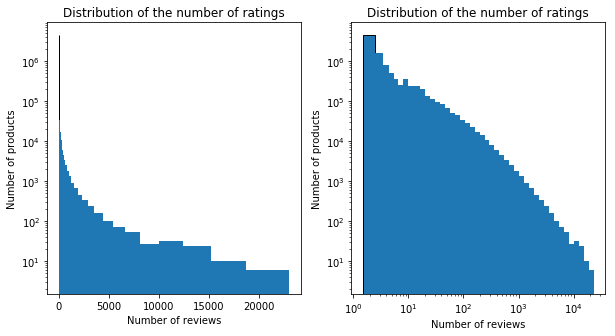

In [14]:
#Function used to draw the distribution of number of reviews per number of products
draw_full_ratings('Full_ratings_count.csv')

We nearly have a power law.

### Ratings distribution

We now observe the distribution of the ratings.

In [15]:
# Do a Group By Product of all the ratings
groupRatingsByRating = df_full_ratings.groupBy('ratings')
# Compute the number of reviews by product
ratings_count_by_rating = groupRatingsByRating.count()

In [16]:
ratings_count_by_rating = ratings_count_by_rating.selectExpr('ratings', 'count as number_of_review')
ratings_count_by_rating.printSchema()

root
 |-- ratings: float (nullable = true)
 |-- number_of_review: long (nullable = false)



In [17]:
# Compute the number of ratings by rating as a pandas dataframe for easier use
df_ratings_distribution_pd = ratings_count_by_rating.toPandas()
# Save the number of ratings by product to a csv files
df_ratings_distribution_pd.to_csv('Full_ratings_distribution.csv')

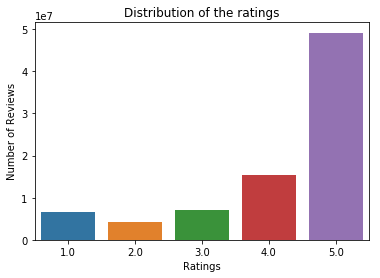

In [18]:
ax = sns.barplot(x = df_ratings_distribution_pd['ratings'], y = df_ratings_distribution_pd['number_of_review'])
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of the ratings')
plt.show()

The ratings have a clear tendency to be >=4 

## Analysis of the distribution for each categories

Here are implemented functions used to load a category and output the distributions of the reviews

### Electronics Data

In [19]:
# Function used to load a category dataset using spark
df_electronics = load_file_cat("reviews_Electronics.json.gz",'json',spark)
# Get the number of distinct reviewers in the category
distinct_reviews_electronics = df_electronics.count()
print("There is " + str(distinct_reviews_electronics) + " distinct reviews")

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)

There is 7824482 distinct reviews


In [20]:
# Function used to compute the number of review per product using a spark
# dataframe and save it as a pandas dataframe
df_review_count_electronics_pd = compute_review_per_product(df_electronics,'Electronics_Review_Count.csv')

Let's vizualise the distribution :

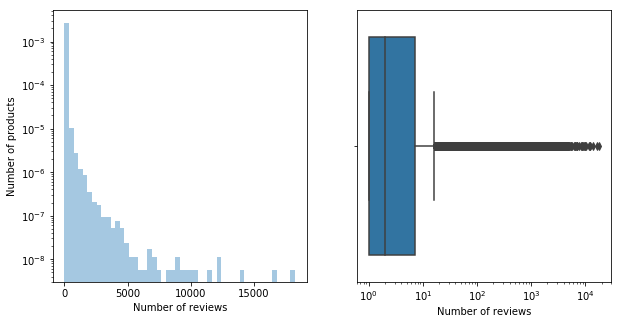

In [21]:
#Function used to draw the distribution of number of reviews per
#number of products
draw_distribution(csv = 'Electronics_Review_Count.csv')

In [22]:
# Compute the statistics of the number of reviews by product
df_review_count_electronics_pd.describe()

,count
count,476002.000000
mean,16.437918
std,112.702633
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,18244.000000


We see that the majority of products have less than 2 reviews, as we want to do a study on multiple reviews for each reviewer and products, we will use the 5-cores dataset for electronics.

### Office Products Data

In [24]:
df_office = load_file_cat("reviews_Office_Products.json.gz",'json',spark)
# Get the number of distinct reviewers in the category
distinct_reviews_office = df_office.count()
print("There is " + str(distinct_reviews_office) + " distinct reviews")

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)

There is 1243186 distinct reviews


In [25]:
df_review_count_office_pd = compute_review_per_product(df_office,'Office_Review_Count.csv')

Let's vizualise the distribution :

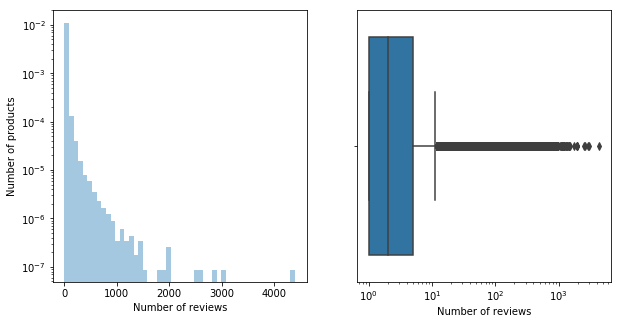

In [26]:
draw_distribution(csv = 'Office_Review_Count.csv')

In [27]:
# Compute the quantiles of the number of reviews by product
df_review_count_office_pd.describe()

,count
count,130006.000000
mean,9.562528
std,44.592114
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4398.000000


## What's next in this section ?

- We will expand our analysis to the other categories.
- We will also analyze the UNIX time of the reviews (already load in the full_ratings).

# Cleaning and analysis of the 5-core electronic data

## What's in this section?

In this section, we take a look at the review of products and its reviewer. More precisly we look in details at all the reviewers of a product and make analysis about what the reviewer reviewed before, what is its mean rating, mean length of its review in order to get more insight about the global rate of the product.  

For now, we just take the 5-core electronics reviews of our dataset and we will change later for all the reviews. This is just for milestone 2 and to help us building a pipeline for our project.

In [1]:
import ast

We create functions that are saved in helpers_functions.py. We provided comments and descriptions about this functions in the file but we summarize here that: 
- Some functions helps us load the dataframe correctly. (cleaning part)
- Some functions helps us enrich the dataset. (analysis part)
- Some functions helps us vizualise the data and get more insight about what we had. (plot part)

In [2]:
from helpers_functions import *

This part starts by reading and cleaning the data we got from the 5-core dataset provided. We decided to keep only the useful data and we change some columns in order to have it as we want. We dropped the time (UTC), the name of the reviewer, imageURL and the product description.

In [3]:
#load the electronics data.
Elec_Data = pd.read_csv('Electronic_Review_And_MetaData_Dataframe.csv',index_col = ['Product ID', 'Reviewer ID'])

In [4]:
#Load the dataframe.
df = read_DataFrame_From_CSV()

#Reset the index.
df = df.reset_index()

#We fill the na values of the Review Text column with a string 'None'.
df['Review Text'] = df['Review Text'].fillna('None')

#df.set_index(['Reviewer ID','Product ID'])
df = df.set_index('Reviewer ID')

#Look at the head.
df.head()

,Product ID,Product Title,Product Price,Brand,Categories,Review Summary,Review Rating,Review Text,Review Time,Helpfulness Votes,Sales Rank,Related Products
Reviewer ID,,,,,,,,,,,,
AO94DHGC771SJ,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",Gotta have GPS!,5.0,We got this GPS for my husband who is an (OTR)...,1370131200,"[0, 0]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
AMO214LNFCEI4,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",Very Disappointed,1.0,"I'm a professional OTR truck driver, and I bou...",1290643200,"[12, 15]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
A3N7T0DY83Y4IG,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",1st impression,3.0,"Well, what can I say. I've had this unit in m...",1283990400,"[43, 45]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
A1H8PY3QHMQQA0,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...","Great grafics, POOR GPS",2.0,"Not going to write a long review, even thought...",1290556800,"[9, 10]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
A24EV6RXELQZ63,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...","Major issues, only excuses for support",1.0,I've had mine for a year and here's what we go...,1317254400,"[0, 0]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."


Now that our dataframe is clean we can check what are the most reviewed article and what are the least reviewed.

In [12]:
#Reset the index.
articles = df.reset_index()

#Set it as the product id.
articles = articles['Product ID']

#count all the values in the articles
articles = articles.value_counts()

#keep the 10 most reviewed article.
most_reviewed = articles[:10]

#keep the 10 least reviewed article.
least_reviewed = articles[-10:]

#have a look at the most reviewed
most_reviewed

B007WTAJTO    4915
B003ES5ZUU    4143
B00DR0PDNE    3798
B0019EHU8G    3435
B002WE6D44    2813
B003ELYQGG    2652
B0002L5R78    2599
B009SYZ8OC    2542
B00BGGDVOO    2104
B002V88HFE    2082
Name: Product ID, dtype: int64

In [13]:
#have a look at the least reviewed to take it as an example
#for the rest of the notebook.
least_reviewed

B000V1PB02    5
B004H3WWU2    5
B00H5XDVG0    5
B000GAVT5E    5
B001E27QSW    5
B0074FWMXC    5
B00HFRYAGQ    5
B003MEVQRC    5
B001QXDMXC    5
B001PNMCYS    5
Name: Product ID, dtype: int64

We look at the data of a reviewer (of a certain product). It shows us the mean rate, the mean length of the reviews, the number of reviews as a dataframe.

In [6]:
#Data about reviewer A33WCB5866XN09.
#Function that computes statistics on the reviewer, it returns the mean rate, all the rates, the length and the mean 
#lengths of all reviews, the number of reviews and the categories of the item it purchases.
stat_reviewer = statistics(df,'A33WCB5866XN09')
stat_reviewer

,Reviewer,length curr_review,mean_rates,mean_review_length,number_reviews,rates,review(s)_length,Electronics,Portable Audio & Video,MP3 Players & Accessories,...,Audio & Video Accessories,TV Accessories & Parts,Rear Projection TV Replacement Lamps,Telephone Accessories,Batteries,Car & Vehicle Electronics,Vehicle Electronics Accessories,Antennas,Computer Cable Adapters,Hard Drive Enclosures
0,A33WCB5866XN09,29,4.9,44.5,10,"[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[29, 35, 31, 33, 21, 124, 24, 27, 57, 64]",10,1,1,...,3,2,2,1,1,1,1,1,1,1


We can do the same with a product and have the detailed data of all the reviewers of this product.

In [7]:
#Data about product B00005NHAK.
#Function that returns the statistics about all the reviewer of a product. 
#See helpers_functions.py for more details.
stat_product = statistics_product(df,'B00005NHAK')

#look at the result.
stat_product

,Reviewer,Rate reviewer,mean_rates,length curr_review,mean_review_length,number_reviews,rates,review(s)_length,Electronics,APS Cameras,...,USB Flash Drives,USB Network Adapters,USB Port Cards,Vehicle Electronics Accessories,Video Cables,Video Surveillance,Webcams,Wireless Access Points,Zip Discs,xD-Picture Cards
0,A3E0PQ1LJAKWZ,2.0,2.818182,86,67.000000,11,"[2.0, 1.0, 5.0, 5.0, 3.0, 2.0, 4.0, 1.0, 1.0, ...","[86, 48, 28, 77, 32, 164, 51, 22, 90, 108, 31]",11,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A7IKOAH6M8WAC,5.0,4.285714,36,84.000000,14,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 1.0, ...","[36, 29, 56, 66, 214, 28, 111, 28, 63, 117, 88...",14,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,A2HONG3KI05QIX,4.0,4.857143,51,146.714286,7,"[5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0]","[51, 134, 274, 51, 102, 128, 287]",7,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A231WM2Z2JL0U3,4.0,4.401235,69,158.839506,162,"[4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, ...","[69, 62, 66, 68, 86, 41, 227, 119, 67, 76, 48,...",162,1.0,...,3.0,4.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
4,AWW0JIUH84TIK,3.0,3.526316,171,251.368421,19,"[3.0, 4.0, 4.0, 1.0, 4.0, 4.0, 1.0, 3.0, 5.0, ...","[171, 154, 138, 160, 267, 123, 184, 28, 137, 4...",18,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's vizualise some data.

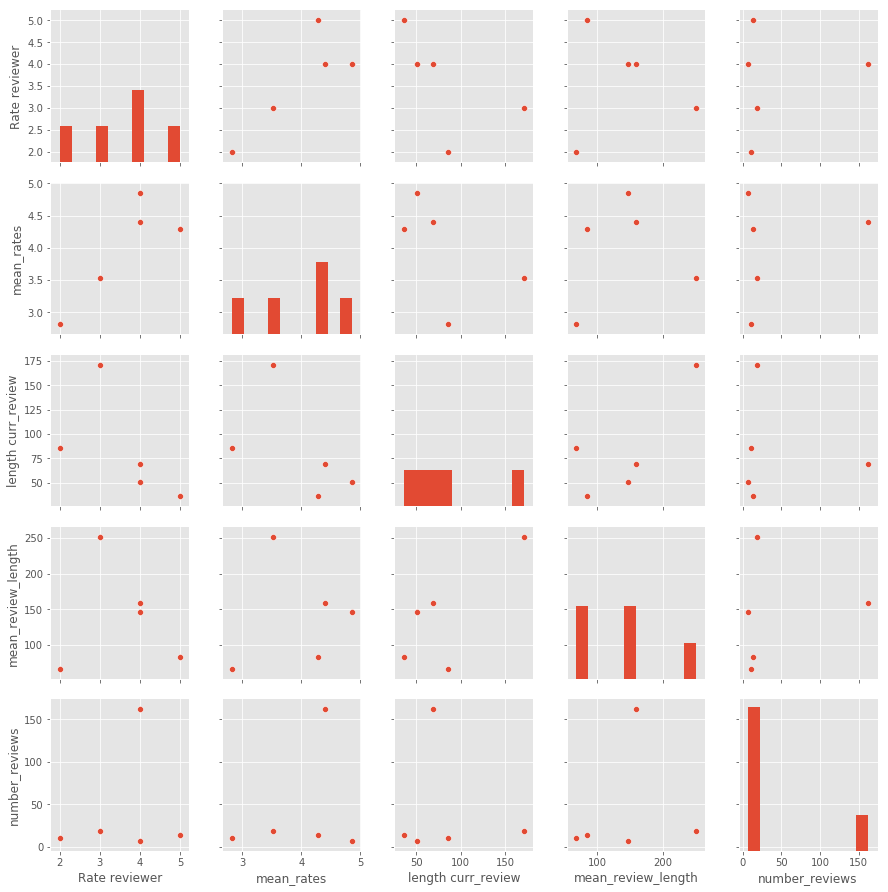

In [8]:
#Analyse the parity of the columns.
#Function that plot the parity of the columns of interest of our review-dataframe.
analyse_pair(stat_product)

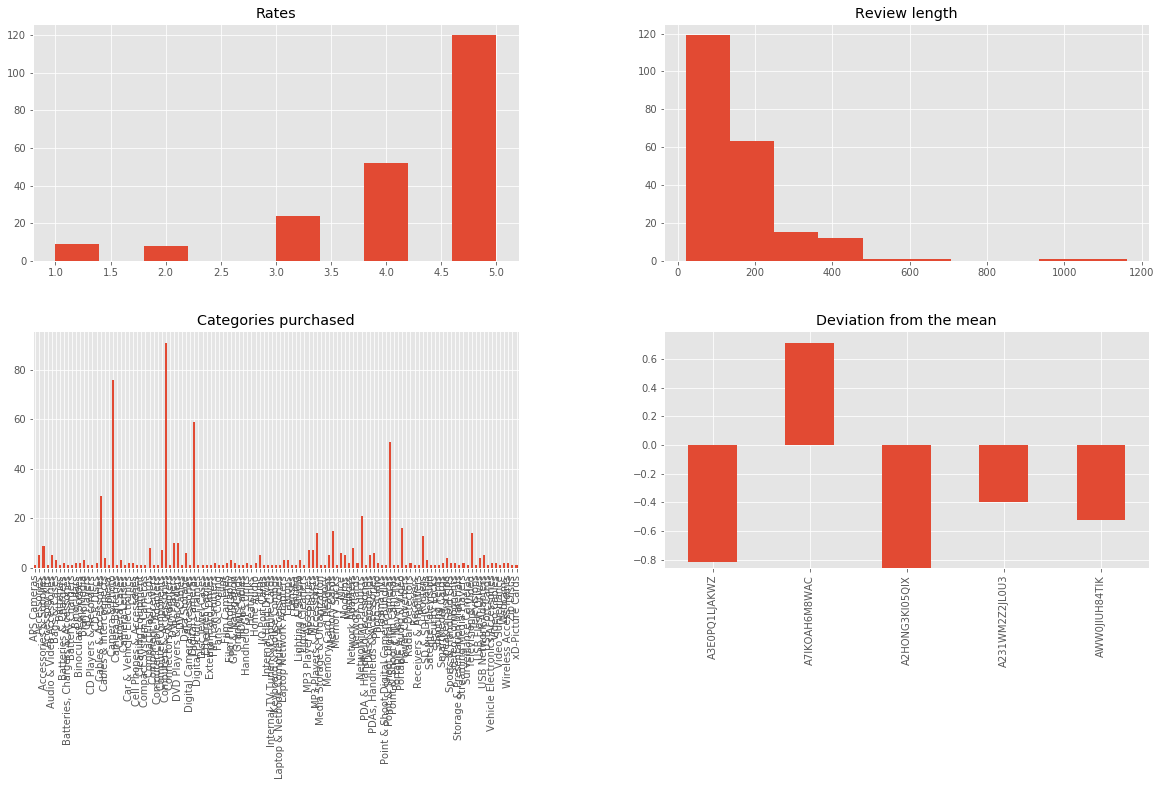

In [9]:
#other plots.
#Function that plot some interesting plots
analyse_ref(stat_product)

In [10]:
#Correlation between the length of the review and the rate.
#Function that calculate the correlation between the length of the review and the rate of the review.
corr = corr_len_rate(stat_product)
corr

,length curr_review,Rate reviewer
length curr_review,1.000000,-0.588072
Rate reviewer,-0.588072,1.000000


## What's next in this section?

The goal will be to have enough data to compute a new rate in relation with the data we collect and the sentiment analysis of the review from the other section. At the end, for a given product we will have detailed statistics and a new rating based on our analysis. We will use our pipeline for the other categories.

# Sentiment analysis

## What's in this section ?

In this part, we work on the reviews of the product in the Electronics category, read from the 5-core data set. We want to analyze the sentiment that is given by the review : is it positive or negative ? How does it relate to the rating given by the reviewer ?

To do this, we use the nltk python library, in particular the Vader module which can determine the sentiment of a text. The library provides a grade of the positiveness and negativeness of a text, and an average of the two : compound. We will use this last value for our analysis.

We start by importing the nltk library and the `Vader` module

In [33]:
import nltk.data

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer

In [34]:
# We instantiate the sentiment analizer 
sid = SentimentIntensityAnalyzer()
# lmtzr = WordNetLemmatizer()

We wrap the computation of the nltk compound score of a text in a helper function.

In [35]:
def overall_score(text):
    """ Computes a unique value of sentiment positiveness for the input text 
        Returns: (positiveness_score - negativeness_score) * compound
    """
    polarity_score = sid.polarity_scores(text)
    return polarity_score['compound'] # (blob['pos'] - blob['neg']) * blob['compound']

In [36]:
text = 'marvelous and awful'

In [37]:
sid.polarity_scores(text)

{'compound': 0.2263, 'neg': 0.38, 'neu': 0.127, 'pos': 0.494}

In [38]:
overall_score(text)

0.2263

We wish to see if the distribution of the sentiment is similar to the distribution of the ratings. To better compare the data, we will map the sentiment from \[-1, 1\] to the range of the ratings : \[1,5\]

In [39]:
def mapSentimentToRating(Sentiment):
    """ Maps the sentiment rating of a review (real number between -1 and 1) to
        a rating between 1 and 5. """
    # We use a linear mapping : for any number x in [-1, 1], we map the value
    # (x - (-1)) * (5-1)/(1-(-1)) + 1
    return (Sentiment+1)*2 +1

We will first analyse the sentiment given by the summary (title) of the reviews, and then we will analyse the sentiment given by the texts of the reviews.

We create a new column in the dataframe to store the sentiment of the summary of the reviews, and fill it with the values computed with nltk.

In [40]:
Elec_Data = df

Elec_Data['Review Summary Sentiment'] = np.NaN

Elec_Data['Review Summary Sentiment'] = Elec_Data['Review Summary'].map(lambda r: overall_score(str(r)))

Elec_Data['Review Summary Sentiment'].describe()

count    1.689188e+06
mean     2.877538e-01
std      3.564592e-01
min     -9.691000e-01
25%      0.000000e+00
50%      3.919000e-01
75%      6.249000e-01
max      9.911000e-01
Name: Review Summary Sentiment, dtype: float64

We now map the sentiment to \[1, 5\] to compare them with the gradings

In [41]:
Elec_Data['Review Summary Sentiment'] = mapSentimentToRating(Elec_Data['Review Summary Sentiment'])

In [42]:
Elec_Data['Review Summary Sentiment'].describe()

count    1.689188e+06
mean     3.575508e+00
std      7.129184e-01
min      1.061800e+00
25%      3.000000e+00
50%      3.783800e+00
75%      4.249800e+00
max      4.982200e+00
Name: Review Summary Sentiment, dtype: float64

We plot the distribution of the sentiment ratings

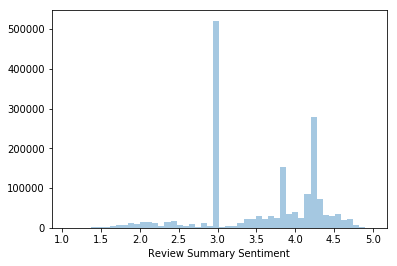

In [45]:
sns.distplot(Elec_Data['Review Summary Sentiment'], kde = False)
plt.show()

The distribution displays two peaks : a center at 3 which indicates a neutral feeling, and a pick between 3.5 and 4.5 which correspond to positive feelings. Most of the reviews feelings are thus neutral or positive.

We now compute the sentiment given by the full text of the reviews

In [46]:
Elec_Data['Review Sentiment'] = np.NaN

In [47]:
Elec_Data['Review Sentiment'] = Elec_Data['Review Text'].map(lambda r: overall_score(str(r)))

In [48]:
Elec_Data['Review Sentiment'].describe()

count    1.689188e+06
mean     5.611259e-01
std      5.047354e-01
min     -9.996000e-01
25%      3.642000e-01
50%      7.844000e-01
75%      9.283000e-01
max      1.000000e+00
Name: Review Sentiment, dtype: float64

We map the sentiment to the rating range :

In [49]:
Elec_Data['Review Sentiment'] = mapSentimentToRating(Elec_Data['Review Sentiment'])

In [50]:
Elec_Data['Review Sentiment'].describe()

count    1.689188e+06
mean     4.122252e+00
std      1.009471e+00
min      1.000800e+00
25%      3.728400e+00
50%      4.568800e+00
75%      4.856600e+00
max      5.000000e+00
Name: Review Sentiment, dtype: float64

As we can see, most of the sentiment of the reviews are between 4 et 5, which is a very positive sentiment. There is also a pick at 3, which correspond to a neutral feeling.

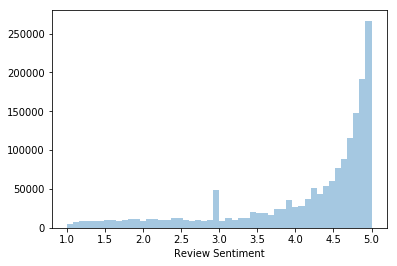

In [51]:
sns.distplot(Elec_Data['Review Sentiment'], kde = False)
plt.show()

We look at the distribution of the reviews sentiment per product:

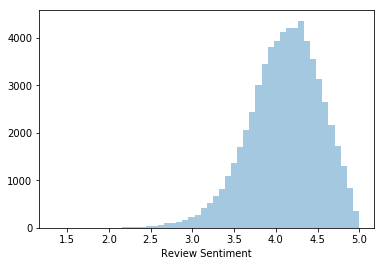

In [58]:
sns.distplot(Elec_Data.groupby(level=0)['Review Sentiment'].mean(), kde = False)
plt.show()

The distribution is very different. We can compare it to the distribution of ratings per product:

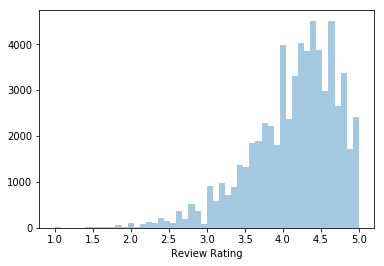

In [59]:
ax = sns.distplot(Elec_Data.groupby(level=0)['Review Rating'].mean(), kde = False)
plt.show()

## What's next

We compared the distribution of the average sentiment and rating of a given product. In the next step, we can compare the sentiment and rating for a given reviewer, and try to derive from these two quantities a method to helps an amazon custumer better understand the review.

# Similarity study

## What's in this section

In this section, we try to assess the similarity between reviews of a same product. The end goal would be to provide a method to detect very similar reviews, so that the amazon customer can have a taste of different reviews.

To do this, we use the library `spacy` which provides method to compute the similarity of two texts, that can handle the use of synonyms. However, the similarity method of spacy does not work well on long texts, so we will first have to split the reviews into chunks in a n-gramm fashion.

We start by importing the library and load the langage model.

In [62]:
import spacy

nlp = spacy.load('en_core_web_lg')

As the spacy library does not perform well on long text, we first split the text into a set of small string, which sizes (in number of words) are determined by the parameter k. For instance the string 'I like bananas' would be splitted with k = 3 into : {'I', 'like', 'bananas', 'I like', 'like bananas', 'I like bananas'}

In [63]:
def shingleWords(doc, k=3):
    """ Creates the set of the k-gramm words in doc
        Arguments:
            doc: unicode encoded string
            k: integer
        Returns: set of k-gramms in doc
    """
    blob = set()
    for j in range(1,k+1):
        tokens = nlp(doc)
        blob = blob.union({ tokens[i:i+j] for i in range(0, len(tokens) - j + 1) })
    return removeNoiseAndCleanSet(blob)

In [64]:
def shingleList(string_list, k=3):
    """ Here string_list is a List of strings to process shingle
        Returns a list of the k gramm word in each string
    """
    docs = [None]*len(string_list)
    for i, string in enumerate(string_list):
        docs[i] = shingleWords(string)
    return docs

To compute the similarity between the sets, we can use the jaccard distance, but it does not capture the use of synonyms in the reviews. To handle this, we use the spacy similarity in a custom distance function.

In [65]:
def jaccard(a, b):
    """ A function to compute jaccard distances between sets. """
    return 1.0 * len(a.intersection(b)) / len(a.union(b))

In [66]:
def myDistance(a,b):
    """ A custom function to compute distances between two sets of texts
        It consists in summing the similarity of each pair of elements
        with an element taken in each set. The similarity computed using the 
        spacy library and takes into account the synonyms.
        The similarities are weighted by the lengths of the strings in the sets,
        because similar long strings provide much more information than similar 
        short strings.
        The result is normed by the sum of the weights (the similarity are in [0, 1])
        so that the final result is in [0, 1]
    """
    distance = 0
    norm = 0
    for token_i in a:
        for token_j in b:
            weight = len(token_i.text + token_j.text)
            distance += token_i.similarity(token_j) * weight
            norm += weight
    distance /= norm
    return distance

Before measuring the distances between sets, we want to remove from the texts the words that do not carry information, such as 'the', 'or'... These are referred as stop_words in `spacy`

In [67]:
#Function to check if the token is a 'noise' word or not
def isNoise(token, noisy_pos_tags = [], min_token_length = 2):     
    """ Determines if a given token is noise """
    is_noise = False
    # if token.pos_ in noisy_pos_tags:
        # is_noise = True 
    if token.is_stop == True:
        is_noise = True
    elif len(token.string) <= min_token_length:
        is_noise = True
    return is_noise 

def cleanup(token, lower = True):
    if lower:
        token = token.lower()
    return token.strip()

In [68]:
def removeNoiseAndCleanSet(tokens_set):
    """ Removes the token judged as noise from the set. """
    
    text_set = set()
    clean_set = set()
    for tokens in tokens_set:
        string = ''
        for token in tokens:
            if(not isNoise(token)):
                string = string + ' ' + token.text.strip()
        if string:
            if not string in text_set:
                text_set.add(string)
                clean_set.add(nlp(string))
    # clean_set = {token for tokens in tokens_set for token in tokens if not isNoise(token)}
    return clean_set

Finaly, we compute the similarity between any review of a given product 

In [72]:
def getReviewsSimilarityMatrix(ProductID):
    """ Get the similarity rating of all the review of the product """
    
    reviews = Elec_Data.loc[ProductID].iloc[:]['Review Text']
    num_reviews = reviews.shape[0]
    tokenList = shingleList(reviews)
    print(tokenList)
    sim_matrix = np.empty([num_reviews, num_reviews])
    for i in range(num_reviews):
        for j in range(num_reviews):
            sim_matrix[i,j] = myDistance(tokenList[i],tokenList[j])
    return sim_matrix

In [70]:
mat = getReviewsSimilarityMatrix('0528881469')

In [71]:
print(mat)

[[ 0.5305967   0.47814056  0.48864703  0.51495024  0.48893193]
 [ 0.47814056  0.45393297  0.44747445  0.47414657  0.4536555 ]
 [ 0.48864703  0.44747445  0.46577286  0.48122497  0.46274962]
 [ 0.51495024  0.47414657  0.48122497  0.51053385  0.48243487]
 [ 0.48893193  0.4536555   0.46274962  0.48243487  0.47152483]]


## What's next ?

The similarity analysis is not very satisfying, since every review is about the same product the scores of the similarity are very close from one another and do not provide very usefull information. We will try to improve the results.